In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from statsmodels.tsa.arima.model import ARIMA

In [2]:
import openpyxl
# Load the currency exchange rate dataset
exchange_rate_dataset = pd.read_excel('FX_FanU.xlsx', skiprows=3)
interested_currencies = ['Name', 'CANADIAN', 'EURO', 'UK', 'YEN', 'KRONA', 'SINGAPORE']

# Filter columns based on whether the header contains a G10 country
filtered_columns = [col for col in exchange_rate_dataset.columns if any(country in col for country in interested_currencies)]

# Select only the filtered columns in the DataFrame
fx_filtered = exchange_rate_dataset[filtered_columns]
fx_filtered = fx_filtered.drop([0, 1]).reset_index(drop = True)
fx_filtered.rename(columns={'Name': 'Date'}, inplace=True)

# Retain only Date
fx_filtered['Date'] = fx_filtered['Date'].astype(str)
fx_filtered['Date'] = fx_filtered['Date'].str.split(' ').str[0]

# Save filtered csv
fx_filtered.reset_index(drop = True)
fx_filtered.to_csv("fx_filtered.csv", index=False)

fx_filtered_train = fx_filtered[(fx_filtered['Date'] >= '2017-12-25') & (fx_filtered['Date'] <= '2018-12-31')]
fx_filtered_test = fx_filtered[(fx_filtered['Date'] >= '2019-12-25')]

In [3]:
currency = {"CA": "CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE", 
            "FR": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "DE": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "IT": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "NL": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "BE": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "UK": "US $ TO UK £ 1M FWD (WMR) - EXCHANGE RATE", 
            "JP": "JAPANESE YEN TO US $ 1M FWD (WMR) - EXCHANGE RATE", 
            "SE": "SWEDISH KRONA TO US $ 1M FWD (WMR) - EXCHANGE RATE", 
            "SG": "SINGAPORE $ TO US $ 1M FWD (WMR) - EXCHANGE RATE"}

In [4]:
# Extract and store the 'Date' column
dates = fx_filtered_train['Date']
test_dates = fx_filtered_test['Date']

# Iterate through the columns and create individual DataFrames
individual_dict, test_dict = {},{}
for column in fx_filtered_train.iloc[:, 1:]:
    individual_dict[column] = pd.DataFrame({column: fx_filtered_train[column]})

for column in fx_filtered_test.iloc[:, 1:]:
    test_dict[column] = pd.DataFrame({column: fx_filtered_test[column]})

In [5]:
# Define a custom dataset and dataloader
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        return (
            self.data[idx:idx+self.seq_length],
            self.data[idx+self.seq_length]
        )

In [6]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

# Run below to change currency

In [7]:
# Normalize the data
scaler = MinMaxScaler()

selection=""
while selection not in currency.keys():
    selection = input("Select currency from [CA, FR, DE, IT, NL, BE, UK, JP, SE, SG]: ").upper()

country = currency[selection]
country_df = individual_dict[country]
country_df = country_df.set_index(dates)
country_test_df = test_dict[country]
country_test_df = country_test_df.set_index(test_dates)

country_df_scaled = scaler.fit_transform(country_df)
country_test_df_scaled = scaler.fit_transform(country_test_df)

# Convert the data to PyTorch tensors
tensor_data = torch.FloatTensor(country_df_scaled)
tensor_test_data = torch.FloatTensor(country_test_df_scaled)

Select currency from [CA, FR, DE, IT, NL, BE, UK, JP, SE, SG]: ca


In [8]:
# Create dataset and dataloader
seq_length = 5
dataset = TimeSeriesDataset(tensor_data, seq_length)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

test_dataset = TimeSeriesDataset(tensor_test_data, seq_length)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [9]:
# Instantiate the model, define loss function and optimizer
input_size = seq_length
hidden_size = 50
output_size = 1
model = LSTMModel(input_size, hidden_size, output_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# arima_model = ARIMA(country_df, order=(1, 1, 1))  # Replace p, d, q with appropriate values
# arima_result = arima_model.fit()
# arima_predictions = arima_result.plot_predict(dynamic=False)
# arima_mse = mean_squared_error(country_test_df[country], arima_predictions)
# print(f'ARIMA MSE: {arima_mse}')

In [10]:
# Training the model
num_epochs = 35
for epoch in range(num_epochs):
    for inputs, target in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/35], Loss: 0.7786
Epoch [2/35], Loss: 0.5717
Epoch [3/35], Loss: 0.3533
Epoch [4/35], Loss: 0.1483
Epoch [5/35], Loss: 0.0559
Epoch [6/35], Loss: 0.0660
Epoch [7/35], Loss: 0.0948
Epoch [8/35], Loss: 0.0969
Epoch [9/35], Loss: 0.0809
Epoch [10/35], Loss: 0.0671
Epoch [11/35], Loss: 0.0616
Epoch [12/35], Loss: 0.0589
Epoch [13/35], Loss: 0.0537
Epoch [14/35], Loss: 0.0466
Epoch [15/35], Loss: 0.0400
Epoch [16/35], Loss: 0.0342
Epoch [17/35], Loss: 0.0285
Epoch [18/35], Loss: 0.0226
Epoch [19/35], Loss: 0.0171
Epoch [20/35], Loss: 0.0122
Epoch [21/35], Loss: 0.0080
Epoch [22/35], Loss: 0.0046
Epoch [23/35], Loss: 0.0024
Epoch [24/35], Loss: 0.0011
Epoch [25/35], Loss: 0.0006
Epoch [26/35], Loss: 0.0006
Epoch [27/35], Loss: 0.0007
Epoch [28/35], Loss: 0.0007
Epoch [29/35], Loss: 0.0007
Epoch [30/35], Loss: 0.0007
Epoch [31/35], Loss: 0.0007
Epoch [32/35], Loss: 0.0006
Epoch [33/35], Loss: 0.0006
Epoch [34/35], Loss: 0.0006
Epoch [35/35], Loss: 0.0006


In [11]:
torch.save(model.state_dict(), fr'{selection}_model.pth')
print("Model saved!")

Model saved!


In [12]:
model.load_state_dict(torch.load(fr'{selection}_model.pth'))

# Evaluation
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
with torch.no_grad():  # Disable gradient calculation during evaluation
    # Initialize a list to store values
    inputs_list, pred_actual_list = [], []

    # Iterate through the dataset for evaluation
    for inputs, target in test_dataloader:
        outputs = model(inputs)
        loss = criterion(outputs, target)
        
        # Accumulate the test loss
        test_loss += loss.item()
        
        # Inverse transform the scaled prediction
        pred_actual = scaler.inverse_transform(np.concatenate((inputs.squeeze().numpy(), outputs.squeeze().numpy().reshape(-1, 1)), axis=1))[:, -1]
        
        # Append the predicted values to the list
        pred_actual_list.append(pred_actual)

# Calculate the average test loss
avg_test_loss = test_loss / len(test_dataloader)

# Print the average test loss
print(f'Average Test Loss: {avg_test_loss:.4f}')

# Flatten the list of predictions
pred_actual = np.concatenate(pred_actual_list)

Average Test Loss: 0.0024


In [13]:
pred_df = pd.DataFrame(list(zip(test_dates.iloc[5:],pred_actual)))
pred_df.to_excel( selection + "_pred.xlsx")

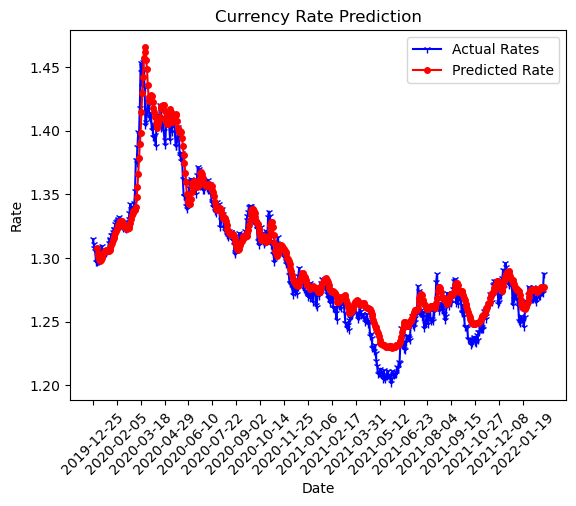

In [14]:
plt.plot(test_dates, country_test_df[country], marker='1', label='Actual Rates', color='blue')
plt.plot(test_dates.iloc[5:],  pred_actual, marker='.', markersize=8, label='Predicted Rate', color='red')
plt.title('Currency Rate Prediction')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
interval = 30
# interval = 10
plt.xticks(test_dates.iloc[::interval], rotation=45)
# plt.xlim(test_dates.iloc[0], test_dates.iloc[100])
plt.show()

In [15]:
print(test_dates.head())
print(country_test_df)

9648    2019-12-25
9649    2019-12-26
9650    2019-12-27
9651    2019-12-30
9652    2019-12-31
Name: Date, dtype: object
           CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE
Date                                                      
2019-12-25                                         1.31486
2019-12-26                                         1.31126
2019-12-27                                         1.30793
2019-12-30                                         1.30525
2019-12-31                                         1.29654
...                                                    ...
2022-02-18                                         1.27388
2022-02-21                                         1.27413
2022-02-22                                         1.27316
2022-02-23                                         1.27244
2022-02-24                                          1.2877

[567 rows x 1 columns]


## Work on Oxford Dataset

In [16]:
# Load the OxCGRT dataset
dtypes = {'RegionName': str, 'RegionCode': str}
oxcg_dataset = pd.read_csv('OxCGRT_compact_national_v1.csv', dtype=dtypes)
interested_countries = ['Canada', 'France', 'Germany', 'Italy', 'Netherlands', 'Belgium', 'United Kingdom', 'Japan', 'Sweden', 'Singapore']

# Filter the dataset to include only the G10 countries and Singapore
oxcg_filtered = oxcg_dataset[oxcg_dataset['CountryName'].isin(interested_countries)]

# Change formatting of date
def convert_date(date):
    original_date = datetime.strptime(str(date), '%Y%m%d')
    formatted_date_str = original_date.strftime('%Y-%m-%d')
    return formatted_date_str

oxcg_filtered['Date'] = oxcg_filtered['Date'].apply(convert_date)

# List of columns to drop
columns_to_drop = ["V1_Vaccine Prioritisation (summary)","V2A_Vaccine Availability (summary)","V2B_Vaccine age eligibility/availability age floor (general population summary)",
                   "V2C_Vaccine age eligibility/availability age floor (at risk summary)","V2D_Medically/ clinically vulnerable (Non-elderly)","V2E_Education",
                   "V2F_Frontline workers  (non healthcare)","V2G_Frontline workers  (healthcare)","V3_Vaccine Financial Support (summary)",
                   "V4_Mandatory Vaccination (summary)","ConfirmedDeaths","MajorityVaccinated","PopulationVaccinated",
                   "StringencyIndex_Average","GovernmentResponseIndex_Average","ContainmentHealthIndex_Average","EconomicSupportIndex",
                   "E1_Flag","H1_Flag","H7_Flag","C1M_Flag","C2M_Flag","C3M_Flag","C4M_Flag","C5M_Flag","C6M_Flag","C7M_Flag","H6M_Flag","H8M_Flag"]

# Drop unwanted columns
oxcg_filtered = oxcg_filtered.drop(columns=columns_to_drop)

oxcg_filtered = oxcg_filtered[(oxcg_filtered['Date'] <= '2022-02-24')]

grouped = oxcg_filtered.groupby('CountryName')

# Fill missing values within each group
oxcg_filtered = grouped.apply(lambda group: group.fillna(method='bfill').fillna(method='ffill'))

# Reset the index to get a flat DataFrame
oxcg_filtered = oxcg_filtered.reset_index(drop=True)

for group_name, group_data in grouped:
    country = f"Countries data\\{group_name}_policy.csv"
    group_data.to_csv(country)

# Save filtered csv
oxcg_filtered.to_csv("OxCGRT_compact_national_v1_filtered.csv")

C:\Users\Admin\AppData\Local\Temp\ipykernel_4392\2407441561.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oxcg_filtered['Date'] = oxcg_filtered['Date'].apply(convert_date)
C:\Users\Admin\AppData\Local\Temp\ipykernel_4392\2407441561.py:33: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  oxcg_filtered = grouped.apply(lambda group: group.fillna(method='bfill').fillna(method='ffill'))


In [17]:
country = {"CA": ["Canada", "CAD"], 
            "FR": ["France", "EUR"],
            "DE": ["Germany", "EUR"],
            "IT": ["Italy", "EUR"],
            "NL": ["Netherlands", "EUR"],
            "BE": ["Belgium", "EUR"],
            "UK": ["United Kingdom", "GBP"],
            "JP": ["Japan", "YEN"],
            "SE": ["Sweden", "KR"],
            "SG": ["Singapore", "SGD"]}

In [18]:
oxcg_filtered = oxcg_filtered[oxcg_filtered["CountryName"] == country[selection][0]]

oxcg_filtered['DailyChange'] = oxcg_filtered["ConfirmedCases"].diff()
oxcg_filtered['DailyChange'] = oxcg_filtered['DailyChange'].fillna(0)

oxcg_filtered.drop(columns = "ConfirmedCases", inplace = True)

oxcg_filtered_train = oxcg_filtered[(oxcg_filtered['Date'] < '2021-01-01')]
oxcg_filtered_train = oxcg_filtered_train.reset_index(drop = True)

oxcg_filtered_test = oxcg_filtered[(oxcg_filtered['Date'] >= '2021-01-01')]
oxcg_filtered_test = oxcg_filtered_test.reset_index(drop = True)

In [19]:
# Select relevant features (COVID-19 policy data) and the target variable (exchange rate)
features = ['C1M_School closing', 'C2M_Workplace closing', 'C3M_Cancel public events', 'C4M_Restrictions on gatherings', \
            'C5M_Close public transport', 'C6M_Stay at home requirements', 'C7M_Restrictions on internal movement', \
            'C8EV_International travel controls', 'E1_Income support', 'E2_Debt/contract relief', 'E3_Fiscal measures', \
            'E4_International support', 'H1_Public information campaigns', 'H2_Testing policy', 'H3_Contact tracing', \
            'H4_Emergency investment in healthcare', 'H5_Investment in vaccines', 'H6M_Facial Coverings', 'H7_Vaccination policy', \
            'H8M_Protection of elderly people', 'DailyChange']

#### Function to fetch the currenctly selected currency's column name from filtered_fx

In [20]:
def get_fx_rate_column_name(selection, currency_dict):
    if selection in currency_dict:
        return currency_dict[selection]
    else:
        raise ValueError(f"Selection {selection} is not in the currency dictionary.")

currency = {"CA": "CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE", 
            "FR": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "DE": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "IT": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "NL": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "BE": "US $ TO EURO 1M FWD (WMR) - EXCHANGE RATE", 
            "UK": "US $ TO UK £ 1M FWD (WMR) - EXCHANGE RATE", 
            "JP": "JAPANESE YEN TO US $ 1M FWD (WMR) - EXCHANGE RATE", 
            "SE": "SWEDISH KRONA TO US $ 1M FWD (WMR) - EXCHANGE RATE", 
            "SG": "SINGAPORE $ TO US $ 1M FWD (WMR) - EXCHANGE RATE"
}
country_currency_column = get_fx_rate_column_name(selection, currency)


### Merging the datasets (preivous model and selected country's policy df)

In [21]:
import pandas as pd
from datetime import datetime
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# Load the predicted FX rates
fx_rates_predictions = pd.read_excel(f'{selection}_pred.xlsx', usecols="B:C", header=0)
fx_rates_predictions.columns = ['Date', 'Predicted_FX']
fx_rates_predictions['Date'] = pd.to_datetime(fx_rates_predictions['Date'])

# Ensure the 'Date' column in fx_filtered_test is also in datetime format
fx_filtered_test['Date'] = pd.to_datetime(fx_filtered_test['Date'])

# Convert the 'Date' column in oxcg_filtered to datetime
oxcg_filtered['Date'] = pd.to_datetime(oxcg_filtered['Date'])

# Merge the OxCGRT policy data with the predicted FX rates
combined_data = pd.merge(oxcg_filtered, fx_rates_predictions, on='Date', how='inner')
combined_data = pd.merge(combined_data, fx_filtered_test[['Date', country_currency_column]], on='Date', how='inner')

# Extract Year, Month, and Day from the Date
combined_data['Year'] = combined_data['Date'].dt.year
combined_data['Month'] = combined_data['Date'].dt.month
combined_data['Day'] = combined_data['Date'].dt.day


C:\Users\Admin\AppData\Local\Temp\ipykernel_4392\1807866135.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fx_filtered_test['Date'] = pd.to_datetime(fx_filtered_test['Date'])


### Selecting features

In [22]:
features_columns = ['C1M_School closing', 'C2M_Workplace closing', 'C3M_Cancel public events', 
                    'C4M_Restrictions on gatherings', 'C5M_Close public transport', 
                    'C6M_Stay at home requirements', 'C7M_Restrictions on internal movement', 
                    'C8EV_International travel controls', 'E1_Income support', 'E2_Debt/contract relief', 
                    'E3_Fiscal measures', 'E4_International support', 'H1_Public information campaigns', 
                    'H2_Testing policy', 'H3_Contact tracing', 'H4_Emergency investment in healthcare', 
                    'H5_Investment in vaccines', 'H6M_Facial Coverings', 'H7_Vaccination policy', 
                    'H8M_Protection of elderly people', 'DailyChange', 'Year', 'Month', 'Day', 'Predicted_FX']
# features_columns=['Predicted_FX','Day','Month','H2_Testing policy','Month','C8EV_International travel controls']


In [23]:
val = ((len(combined_data)/10)*8)

In [24]:
date_value = combined_data.iloc[448, combined_data.columns.get_loc('Date')]
print(date_value)


2021-09-20 00:00:00


In [25]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch

# Load your data
combined_data = combined_data.sort_values('Date')
combined_data[country_currency_column] = pd.to_numeric(combined_data[country_currency_column], errors='coerce')

# Drop NaN values from the target column
combined_data.dropna(subset=[country_currency_column], inplace=True)
# Split the data chronologically
split_date = pd.to_datetime(date_value)  # Adjust this date to split your data
train_data = combined_data[combined_data['Date'] < split_date]
test_data = combined_data[combined_data['Date'] >= split_date]


test_dates = test_data['Date']
# Define your features and target for training
X_train = train_data[features_columns].values
y_train = train_data[country_currency_column].values 

# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Convert the scaled features and target to tensors
tensor_X_train = torch.FloatTensor(X_train_scaled)
tensor_y_train = torch.FloatTensor(y_train)

# Repeat the process for test data
X_test = test_data[features_columns].values
y_test = test_data[country_currency_column].values  
X_test_scaled = scaler.transform(X_test)  

# Convert the scaled test features to tensors
tensor_X_test = torch.FloatTensor(X_test_scaled)
tensor_y_test = torch.FloatTensor(y_test)

# Verify the shapes
print(tensor_X_train.shape)
print(tensor_y_train.shape)
print(tensor_X_test.shape)
print(tensor_y_test.shape)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(tensor_X_train, tensor_y_train)
test_dataset = TensorDataset(tensor_X_test, tensor_y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

torch.Size([448, 25])
torch.Size([448])
torch.Size([114, 25])
torch.Size([114])


## Training the model

In [26]:
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the last time step
        return out


In [27]:
import torch.optim as optim

input_size = len(features_columns)  # Number of input features
hidden_size = 50  # Number of hidden units
output_size = 1  # Predicting one value
num_layers = 2  # Number of LSTM layers
dropout_rate = 0.5  # Dropout rate

# Instantiate the model
model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout_rate)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [28]:
# Train the model
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs = inputs.view(inputs.shape[0], 1, -1)
        targets = targets.view(-1, 1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/50], Loss: 1.2048
Epoch [2/50], Loss: 0.7466
Epoch [3/50], Loss: 0.1280
Epoch [4/50], Loss: 0.0789
Epoch [5/50], Loss: 0.0264
Epoch [6/50], Loss: 0.0188
Epoch [7/50], Loss: 0.0202
Epoch [8/50], Loss: 0.0177
Epoch [9/50], Loss: 0.0201
Epoch [10/50], Loss: 0.0312
Epoch [11/50], Loss: 0.0122
Epoch [12/50], Loss: 0.0118
Epoch [13/50], Loss: 0.0101
Epoch [14/50], Loss: 0.0090
Epoch [15/50], Loss: 0.0106
Epoch [16/50], Loss: 0.0133
Epoch [17/50], Loss: 0.0100
Epoch [18/50], Loss: 0.0058
Epoch [19/50], Loss: 0.0058
Epoch [20/50], Loss: 0.0083
Epoch [21/50], Loss: 0.0035
Epoch [22/50], Loss: 0.0070
Epoch [23/50], Loss: 0.0058
Epoch [24/50], Loss: 0.0049
Epoch [25/50], Loss: 0.0043
Epoch [26/50], Loss: 0.0023
Epoch [27/50], Loss: 0.0032
Epoch [28/50], Loss: 0.0044
Epoch [29/50], Loss: 0.0024
Epoch [30/50], Loss: 0.0031
Epoch [31/50], Loss: 0.0014
Epoch [32/50], Loss: 0.0032
Epoch [33/50], Loss: 0.0015
Epoch [34/50], Loss: 0.0007
Epoch [35/50], Loss: 0.0012
Epoch [36/50], Loss: 0.0018
E

## Evaluating the model

In [29]:
from sklearn.metrics import mean_squared_error

model.eval()
predictions = []
actuals = []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.view(inputs.shape[0], 1, -1)
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(targets.tolist())

# Calculate metrics
mse = mean_squared_error(actuals, predictions)
print(f'Mean Squared Error: {mse:.4f}')


Mean Squared Error: 0.0008


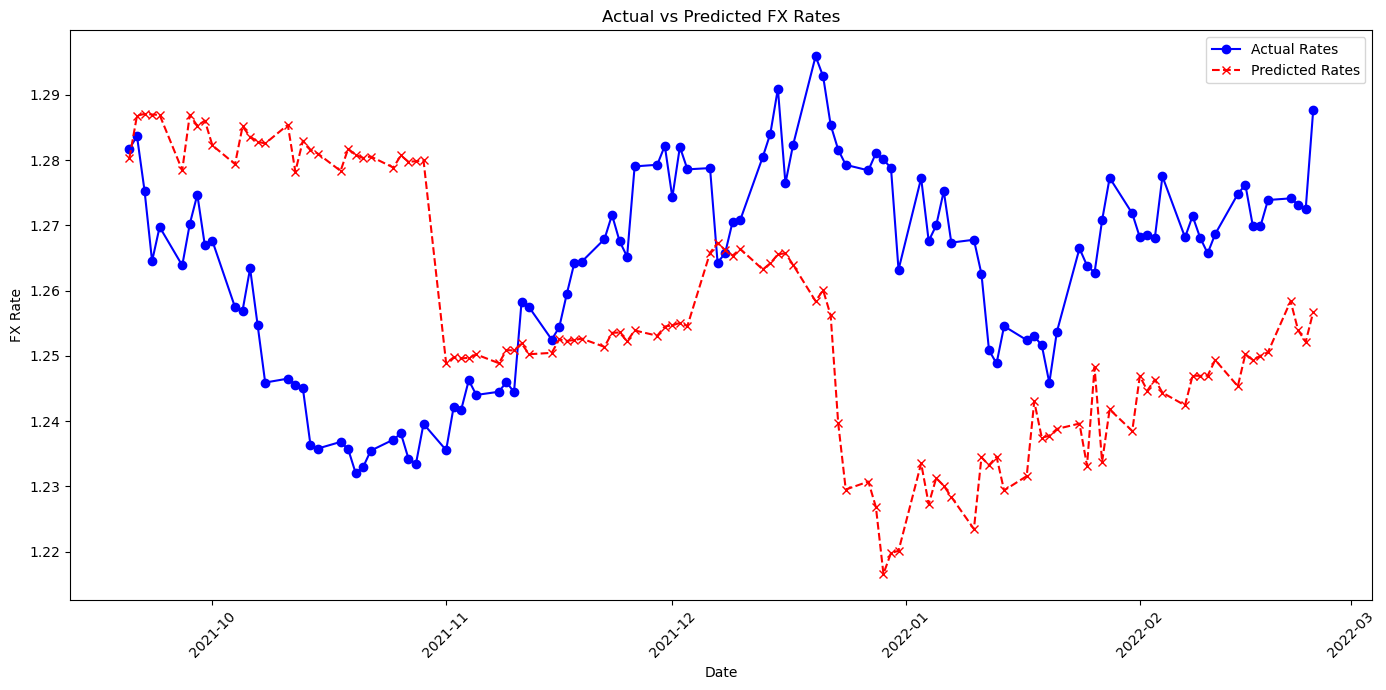

In [30]:
import matplotlib.pyplot as plt

# Convert actuals and predictions to numpy arrays if they aren't already
actuals_np = np.array(actuals)
predictions_np = np.array(predictions)
prredictions_np = predictions_np - 0.2

test_dates_np = test_dates.values

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(test_dates_np, actuals_np, label='Actual Rates', color='blue', marker='o')
plt.plot(test_dates_np, predictions_np, label='Predicted Rates', color='red', linestyle='--', marker='x')

# Labeling the plot
plt.title('Actual vs Predicted FX Rates')
plt.xlabel('Date')
plt.ylabel('FX Rate')
plt.legend()
plt.xticks(rotation=45) 
plt.tight_layout() 

# Show plot
plt.show()


In [31]:
predictions_np = np.array(predictions)
actuals_np = np.array(actuals)

test_dates_subset = test_dates.iloc[len(test_dates) - len(predictions):].reset_index(drop=True)

# Create a DataFrame with dates, actual, and predicted values
results_df = pd.DataFrame({
    'Date': test_dates_subset,
    'Actual': actuals_np,
    'Predicted': predictions_np
})


results_df.to_csv(f"{selection}_model_predictions_with_dates.csv", index=False)

print(f'Results with dates saved to {selection}_model_predictions_with_dates.csv')


Results with dates saved to CA_model_predictions_with_dates.csv


In [32]:
country_test_df = country_test_df.reset_index()

print(country_test_df.columns)

Index(['Date', 'CANADIAN $ TO US $ 1M FWD (WMR) - EXCHANGE RATE'], dtype='object')


First Model - MAE: 0.0084, RMSE: 0.0100
Second Model - MAE: 0.0246, RMSE: 0.0285


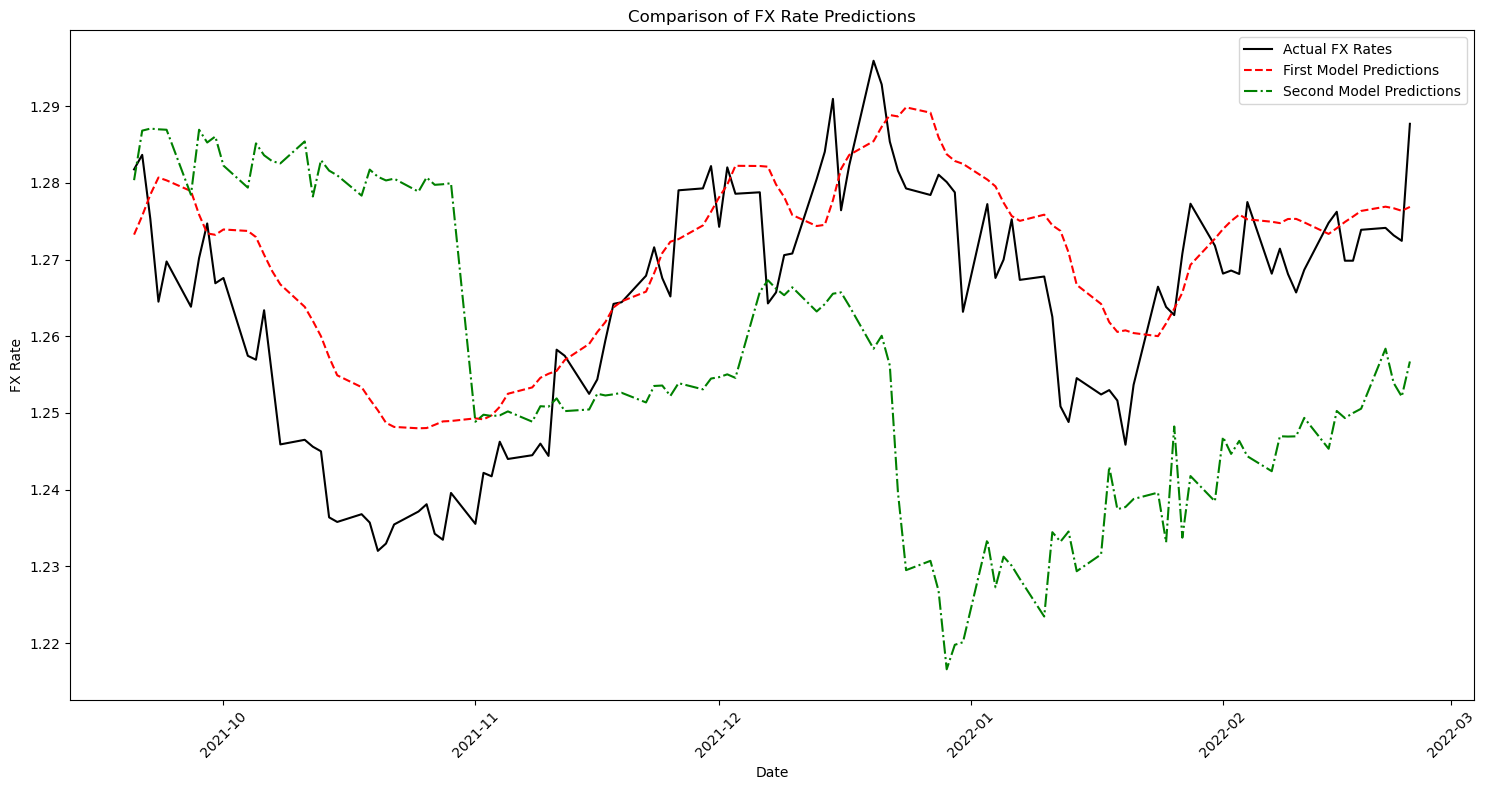

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the predictions from both models
first_model_df = pd.read_excel(f'{selection}_pred.xlsx', usecols="B:C", header=0)
first_model_df.columns = ['Date', 'Predicted_FX_First_Model']
first_model_df['Date'] = pd.to_datetime(first_model_df['Date'])

second_model_df = pd.read_csv(f"{selection}_model_predictions_with_dates.csv")
second_model_df['Date'] = pd.to_datetime(second_model_df['Date'])
second_model_df.rename(columns={'Predicted': 'Predicted_FX_Second_Model'}, inplace=True)

# Convert the 'Date' column in country_test_df to datetime if it's not already
country_test_df['Date'] = pd.to_datetime(country_test_df['Date'])

# Merge the DataFrames on the 'Date' column using 'inner' to avoid NaN values
comparison_df = country_test_df.merge(first_model_df, on='Date', how='inner').merge(second_model_df[['Date', 'Predicted_FX_Second_Model']], on='Date', how='inner')

# Proceed with your analysis and plotting
mae_first = mean_absolute_error(comparison_df[country_currency_column], comparison_df['Predicted_FX_First_Model'])
rmse_first = np.sqrt(mean_squared_error(comparison_df[country_currency_column], comparison_df['Predicted_FX_First_Model']))

mae_second = mean_absolute_error(comparison_df[country_currency_column], comparison_df['Predicted_FX_Second_Model'])
rmse_second = np.sqrt(mean_squared_error(comparison_df[country_currency_column], comparison_df['Predicted_FX_Second_Model']))

print(f'First Model - MAE: {mae_first:.4f}, RMSE: {rmse_first:.4f}')
print(f'Second Model - MAE: {mae_second:.4f}, RMSE: {rmse_second:.4f}')

# Plotting
plt.figure(figsize=(15, 8))
plt.plot(comparison_df['Date'], comparison_df[country_currency_column], label='Actual FX Rates', color='black')
plt.plot(comparison_df['Date'], comparison_df['Predicted_FX_First_Model'], label='First Model Predictions', color='red', linestyle='--')
plt.plot(comparison_df['Date'], comparison_df['Predicted_FX_Second_Model'], label='Second Model Predictions', color='green', linestyle='-.')
plt.title('Comparison of FX Rate Predictions')
plt.xlabel('Date')
plt.ylabel('FX Rate')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
